# JAM3D

In [58]:
import sys,os
from fitlab.resman import RESMAN
from fitlab.mcsamp import MCSAMP
from tools.config import load_config,conf
from tools.tools import load, save,checkdir
from tools.mcstat import chi2hist, parhist
from tools.mcproc import impose_cdf_cut
import pylab as py
import numpy as np
import pandas as pd
import copy
def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' %msg)
    sys.stdout.flush()
%matplotlib inline

In [59]:
runs=load('./summary.mcp')
load_config('./input.py')
checkdir('results')

In [60]:
conf['resman'] = RESMAN(mode='solo',ip=None,nworkers=5)
res=conf['resman'].get_residuals(conf['parman'].par)
npts=len(res[0])
print '\nnumber of data points = ',npts

loading sidis data sets 1007
number of data points =  978


## Chi2 profile for each run

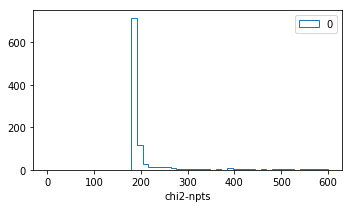

In [61]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*5,nrows*3))

ax=py.subplot(nrows,ncols,1)
R=(0,600)
for k in runs:
    if k=='all': continue
    ax.hist(2*runs[k]['nll']-npts,bins=50,range=R,histtype='step',label=str(k))
ax.legend()
ax.set_xlabel('chi2-npts')
py.tight_layout()

### distribution of parameters

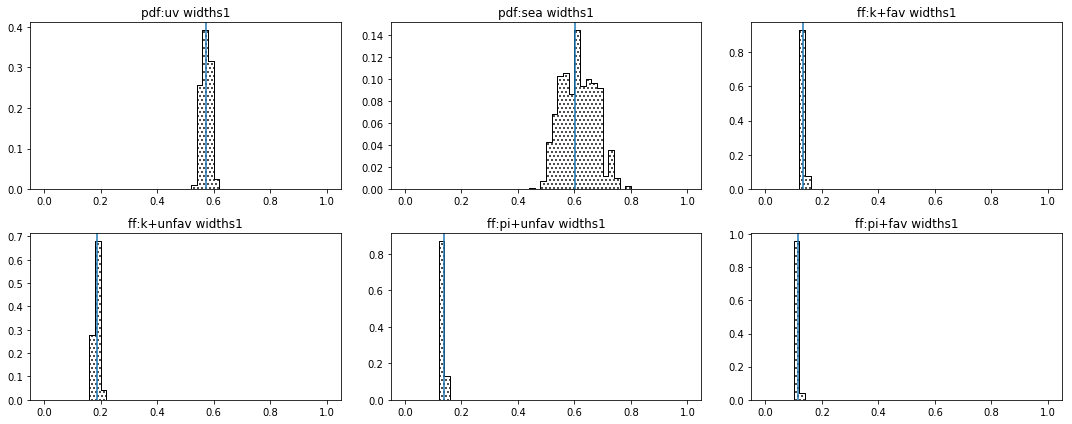

In [62]:
class parhist:

    def __init__(self,runs,inputmod=None):

        self.inputmod=inputmod 
        self.order=self.get_ordered_free_params()
        self.tabs,self.tabs_a=self.get_tabs(runs)

        self.kind1=[]
        self.kind2=[]

        for _ in conf['params']:   self.kind1.append(_)
        for _ in conf['datasets']: self.kind2.append(_)    

    def get_ordered_free_params(self):
        order=[]

        for k in conf['params']:
            for kk in conf['params'][k]:
                if conf['params'][k][kk]['fixed']==False:
                    order.append([1,k,kk])

        if 'datasets' in conf:
            for k in conf['datasets']:
                for kk in conf['datasets'][k]['norm']:
                    if conf['datasets'][k]['norm'][kk]['fixed']==False:
                      order.append([2,k,kk])

        return order

    def get_tabs(self,runs):
        """
        create pandas data frame for the samples
        """
        tabs={}
        tabs_a={}
        for k in runs:
            tab,tab_a={},{}
            tab['nll']=runs[k]['nll']
            tab['weights']=runs[k]['weights']
            samples=np.transpose(runs[k]['samples'])
            active_p=np.transpose(runs[k]['active p'])
            for i in range(len(self.order)):
                _,kind,par=self.order[i]
                tab['%s:%s'%(kind,str(par))]=samples[i]
                tab_a['%s:%s'%(kind,str(par))]=active_p[i]
            tabs[k]=pd.DataFrame(tab)
            tabs_a[k]=pd.DataFrame(tab_a)
        return tabs,tabs_a

    def plot(self,tabs,tabs_a,entries,kind1,kind2,iRange=0):

        for i in range(len(entries)):
            self.cnt+=1
            if entries[i]==None: continue
            ax=py.subplot(self.nrows,self.ncols,self.cnt)
            kind,par=entries[i].split(':')
            for _ in kind1: 
                if kind==_:
                    vmin=conf['params'][_][par]['min']
                    vmax=conf['params'][_][par]['max']
                    R=(vmin,vmax)
                    E0=conf['params'][_][par]['value']
            for _ in kind2: 
                if kind==_:
                    vmin=conf['datasets'][_]['norm'][int(par)]['min']
                    vmax=conf['datasets'][_]['norm'][int(par)]['max']
                    R=(vmin,vmax)
                    E0=conf['datasets'][_]['norm'][int(par)]['value']
            if iRange==0:pass
            else: R=None         

            for _ in tabs:
                if _=='all': continue
                tab=tabs[_]
                ax.hist(tab[entries[i]],range=R,bins=50,weights=tab['weights'],\
                        histtype='step',label=str(_))   

            ax.hist(tabs['all'][entries[i]],range=R,bins=50,\
                    edgecolor='k',hatch='...',\
                    weights=tabs['all']['weights'],histtype='step',label='all')
            
            ax.axvline(E0)
            #ax.plot(tabs_a['all'][entries[i]],np.zeros(tabs_a['all'][entries[i]].size),'ro')
            ax.set_title('%s:%s'%(kind,par))

    def hist_widths(self):

        entries=[]
        for kind in self.kind1:
            for par in conf['params'][kind]:
                for _ in ['widths1','widths2']:
                    if _ in par and conf['params'][kind][par]['fixed']==False:
                        entries.append('%s:%s'%(kind,par))

        if len(entries)==0: return 
        self.ncols=3
        self.nrows=len(entries)/self.ncols
        if len(entries)%self.ncols!=0: self.nrows+=1
        fig = py.figure(figsize=(self.ncols*5,self.nrows*3))
        self.cnt=0
        self.plot(self.tabs,self.tabs_a,entries,self.kind1,self.kind2,iRange=0)
        py.tight_layout()

ph=parhist(runs)
ph.hist_widths()

## purge the samples 

initial size= 1056
final   size= 218


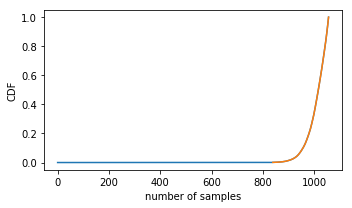

In [63]:
cdfcut=0.001
weights=np.sort(runs['all']['weights'])
cdf0=[]
for i in range(weights.size):
    cdf0.append(np.sum(weights[:i+1]))
cdf=[cdf0[i]  for i in range(weights.size)  if cdf0[i]>cdfcut]
idx=[i  for i in range(weights.size)  if cdf0[i]>cdfcut]

print 'initial size=',len(weights)
weights,samples= impose_cdf_cut(runs['all'],cdfcut) 
print 'final   size=',len(weights)

nrows,ncols=1,1
fig = py.figure(figsize=(ncols*5,nrows*3))

ax=py.subplot(nrows,ncols,1)
ax.plot(range(len(cdf0)),cdf0)
ax.plot(idx,cdf)

ax.set_ylabel('CDF')
ax.set_xlabel('number of samples')
py.tight_layout()

## compute theory values for all samples 

In [64]:
data={'weights':weights}
cnt=0
for s in samples:
    cnt+=1    
    lprint('%d/%d'%(cnt,len(samples)))  
    conf['resman'].get_residuals(s);
    for k in conf['resman'].sidisres.tabs:
        if k  not in data: data[k]=[]
        thy=conf['resman'].sidisres.tabs[k]['thy']    
        norm=conf['datasets']['sidis']['norm'][k]['value']
        shift=conf['resman'].sidisres.tabs[k]['shift']        
        data[k].append(shift+thy/norm)
save(data,'results/%s'%('sidis.dat'))   

218/218

### compute averages and collect results

In [65]:
data=load('results/%s'%('sidis.dat'))   
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].sidisres.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].sidisres.tabs[k]['dthy']=copy.copy(dthy[k])

In [66]:
report=conf['resman'].gen_report(verb=0,level=1)
delimiters=[]
for i in range(len(report)): 
    if 'reaction:' in report[i]: delimiters.append(i) 

data={}
nlines=len(report)
for i in range(len(delimiters)):
    ini=delimiters[i]
    if i==len(delimiters)-1: fin=len(report)
    else: fin=delimiters[i+1]
    reaction=report[ini].replace('reaction:','').strip()
    data[reaction]={'raw data':report[ini:fin]}
    
for k in data:
    print k
    block=data[k]['raw data']
    isep=[i for i in range(len(block)) if '--------' in block[i]][0]
    data[k]['summary']=[block[i] for i in range(isep)]
    data[k]['tables']=[block[i] for i in range(isep+1,len(block))]

    tabs={}
    for l in data[k]['tables']:
        info=l.split(',')
        col=[s for s in info if 'col' in s][0].split('=')[1].strip()
        if col not in tabs: tabs[col]={}
        info=[[ss.strip() for ss in s.split('=')] for s in info if 'col' not in info  if s.strip()!='']
        
        for s in info:
            if s[0] not in tabs[col]: tabs[col][s[0]]=[]
        
        for s in info:
            try:
                value=float(s[1])
            except:
                value=s[1]
            tabs[col][s[0]].append(value)        

    data[k]['tabs']=tabs
save(data,'results/data_and_thy.dat')

sidis


In [67]:
def summary():
    for k in data:
        print ""
        for l in data[k]['summary']: print l
summary()


reaction: sidis
    idx        tar        had        col        obs  npts       chi2      rchi2      nchi2
   1000     proton        pi+     hermes   M_Hermes   127     322.28       0.00       0.00
   1001     proton        pi-     hermes   M_Hermes   124     168.29       0.00       0.00
   1002     proton         k+     hermes   M_Hermes   122      72.20       0.00       0.00
   1003     proton         k-     hermes   M_Hermes   115      42.68       0.00       0.00
   1004   deuteron        pi+     hermes   M_Hermes   124     159.89       0.00       0.00
   1005   deuteron        pi-     hermes   M_Hermes   122     157.78       0.00       0.00
   1006   deuteron         k+     hermes   M_Hermes   122      76.20       0.00       0.00
   1007   deuteron         k-     hermes   M_Hermes   122     169.94       0.00       0.00


### plot data and theory

In [68]:
data=load('results/data_and_thy.dat')

### 1000: tar=p  had=pi+

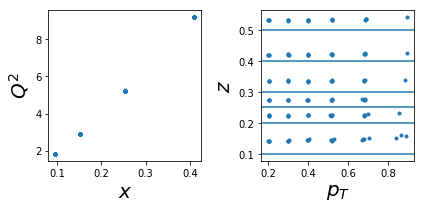

In [69]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1000')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

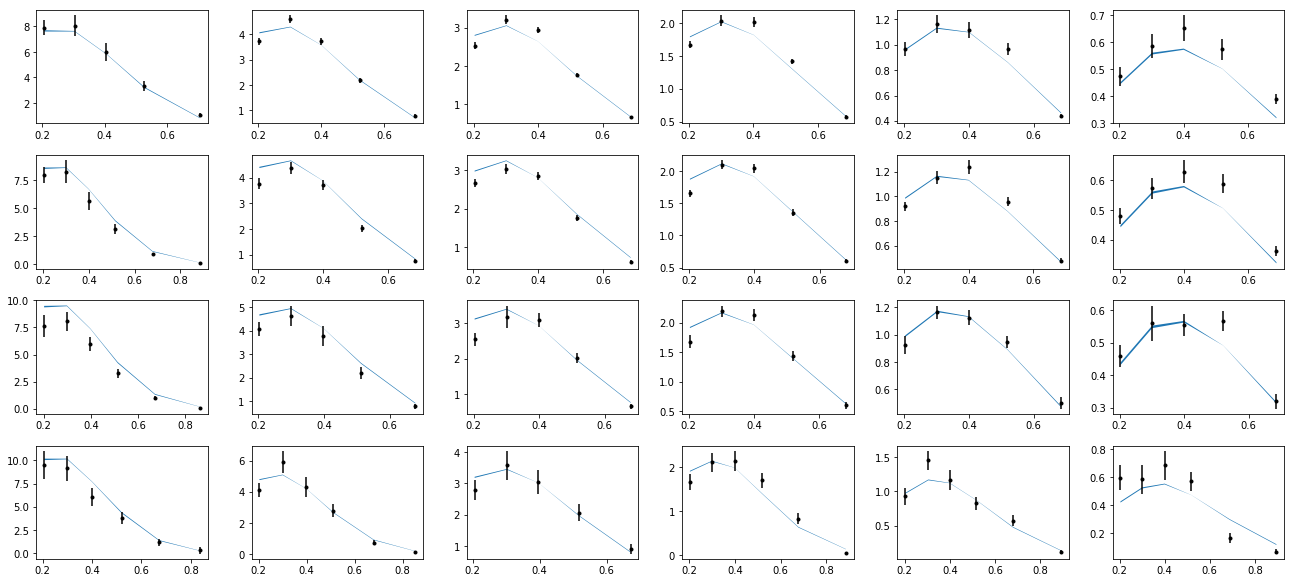

In [70]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1001 tar=p  had=pi-

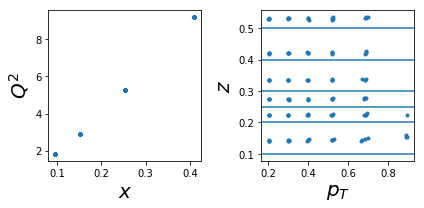

In [71]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1001')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

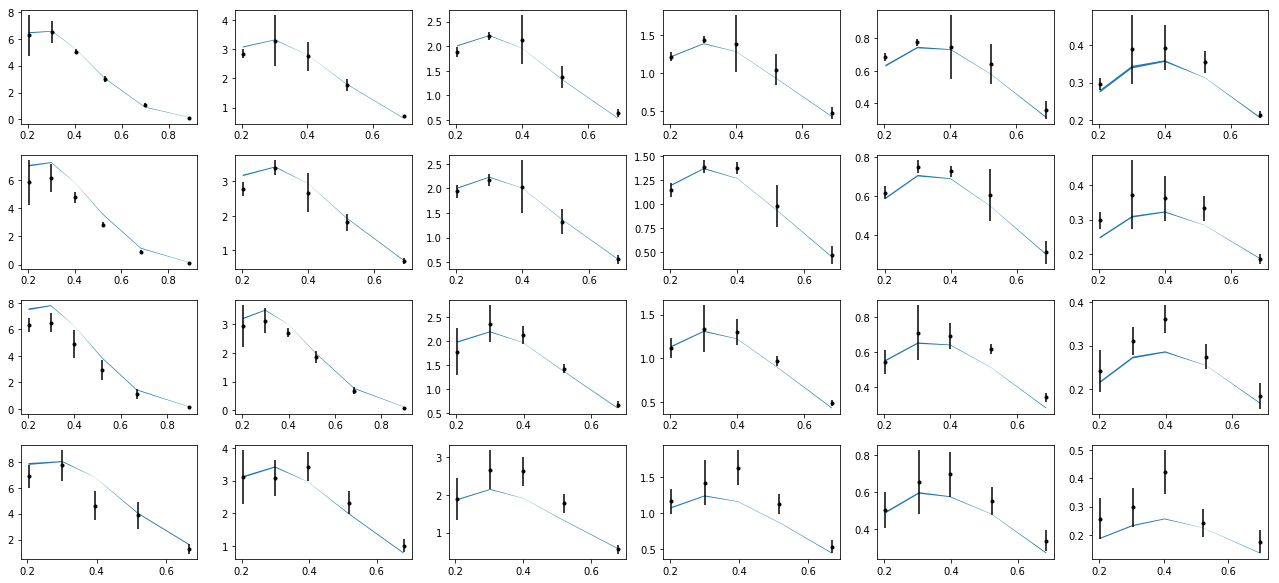

In [72]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1004:  tar=d  had=pi+

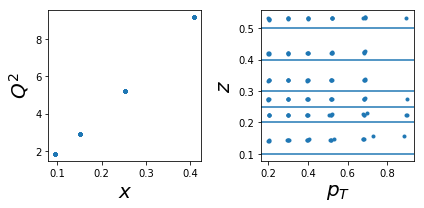

In [73]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1004')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

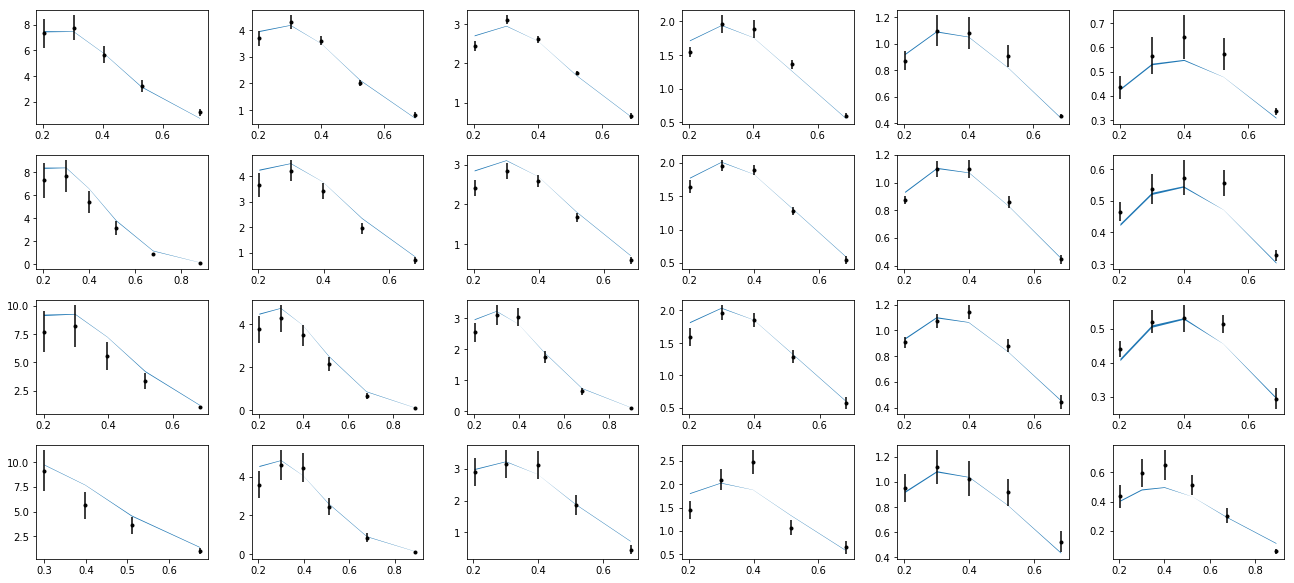

In [74]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1005:  tar=d  had=pi-

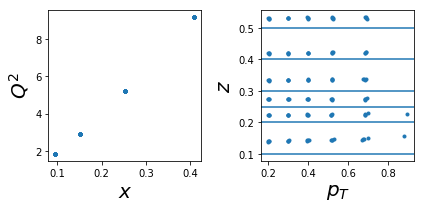

In [75]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1005')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

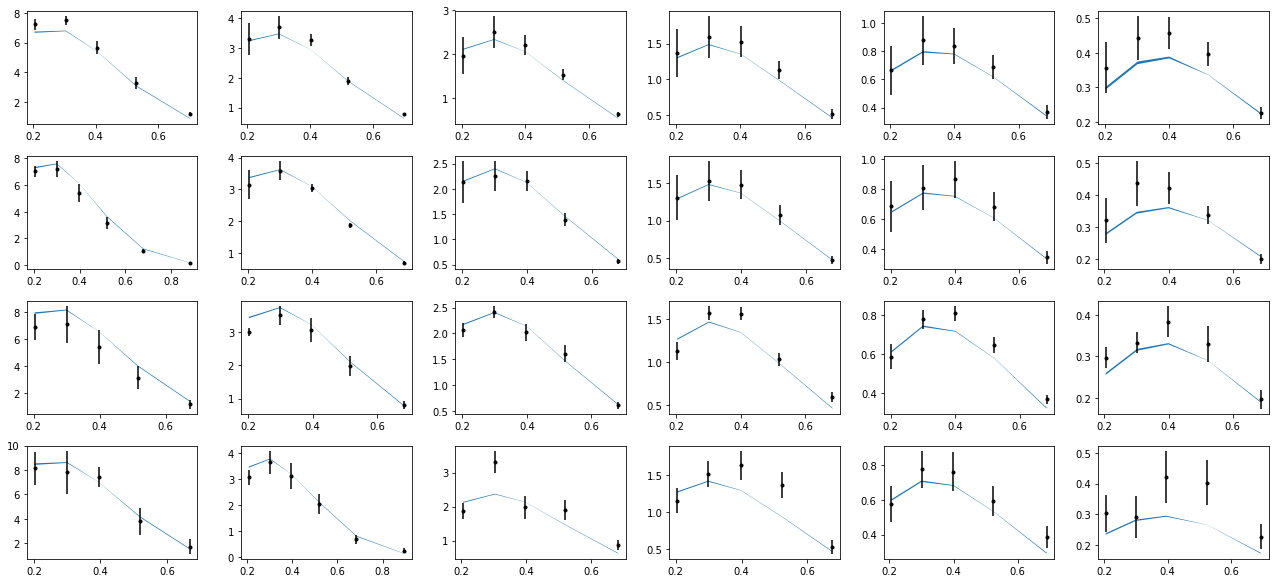

In [76]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1002:  tar=p  had=K+

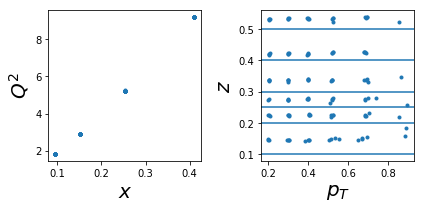

In [77]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1002')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

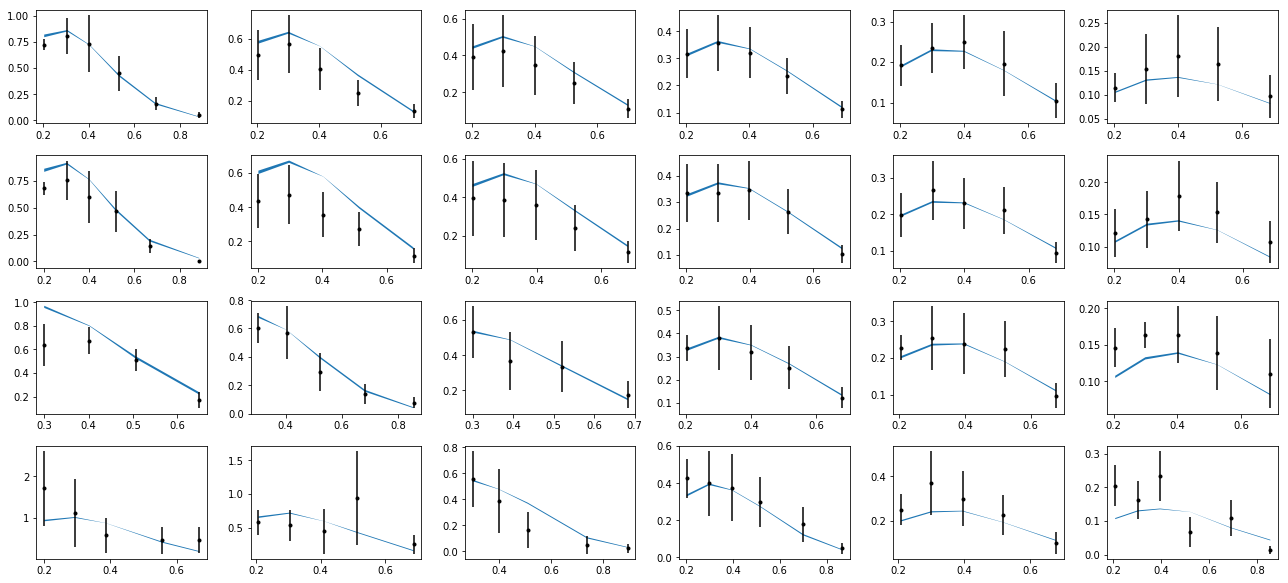

In [78]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1003:  tar=p  had=K-

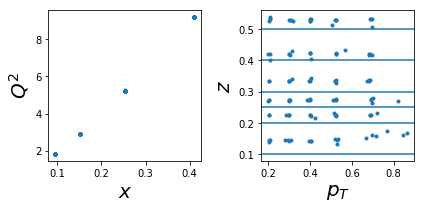

In [79]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1003')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

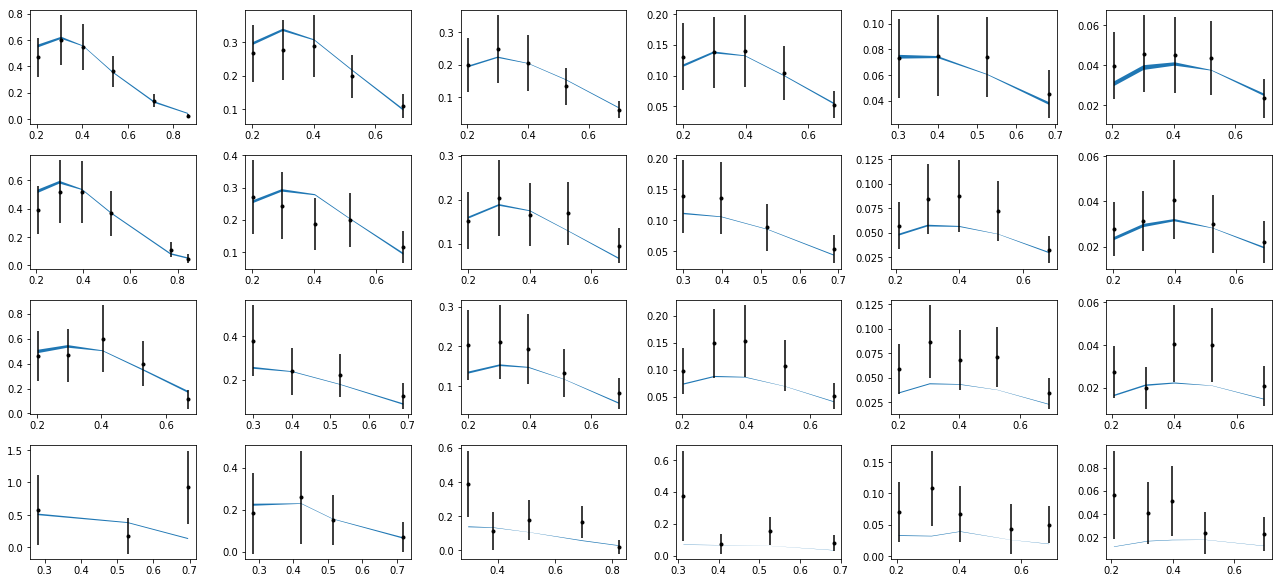

In [80]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1006:  tar=d  had=K+

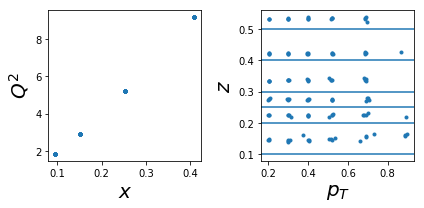

In [81]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1006')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

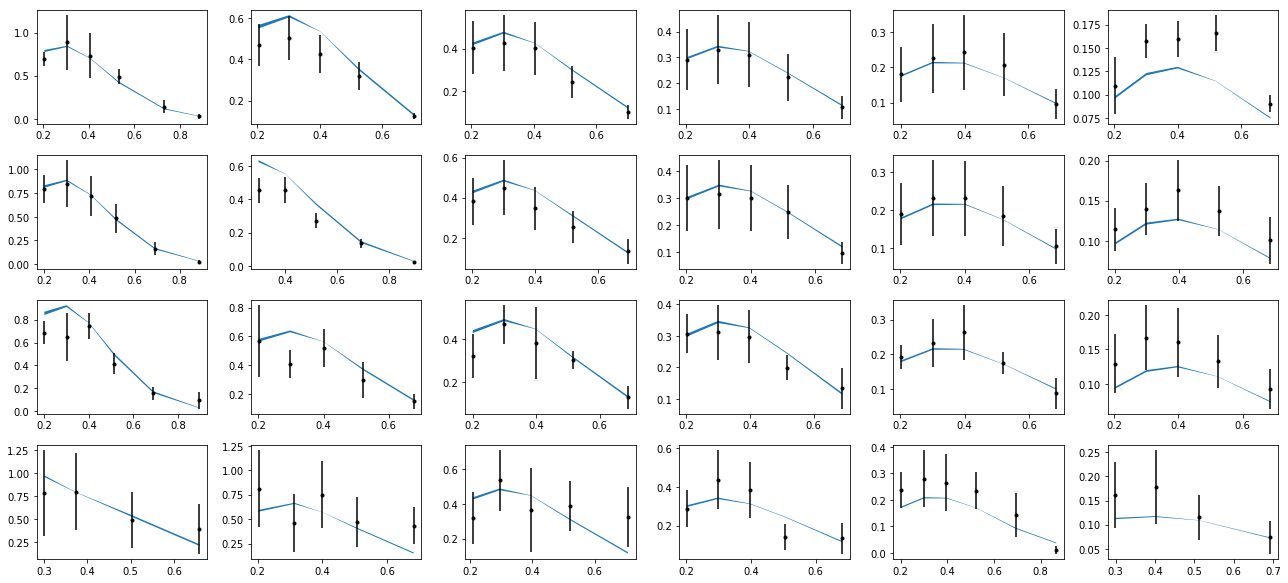

In [82]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1007:  tar=d  had=K-

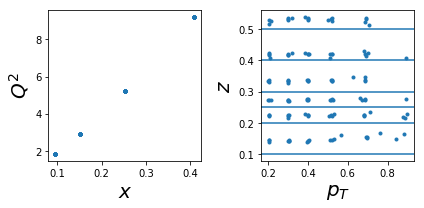

In [83]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1007')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

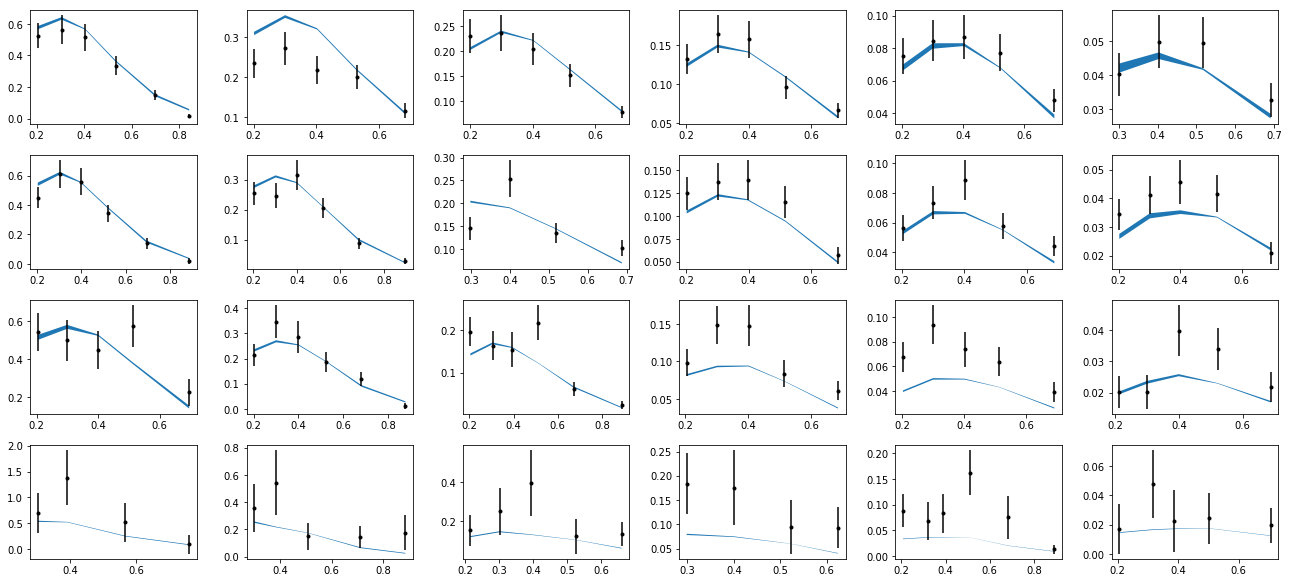

In [84]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()